# IRA and American politics #
## ADA project ##

In this notebook, we explore our data composed of 3 millions tweet. We aim to understand the context of these tweets, their goals and the way they tried to stay hidden mocking real users.

## Imports

In [23]:
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from operator import itemgetter
import collections
from datetime import datetime, date
from sklearn.decomposition import PCA
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import set_credentials_file
import operator
from matplotlib.patches import FancyArrowPatch, Circle
import pickle
import random

import networkx as nx
data = "russian-troll-tweets/"
# data = "../data/"

## Loading and cleaning data

In [13]:
# Loading data
all_data_df = pd.read_csv(data + "IRAhandle_tweets_1.csv")
for i in range(2, 10):
    all_data_df = all_data_df.append(pd.read_csv(data + "IRAhandle_tweets_{}.csv".format(i)), ignore_index=True)
# Cleaning data
all_data_df = all_data_df[pd.notnull(all_data_df["content"])]
all_data_df["publish_date"] = pd.to_datetime(all_data_df["publish_date"], format='%m/%d/%Y %H:%M')
all_data_df['publish_date'] = all_data_df['publish_date'].apply(lambda datetime: datetime.date())

account_categories = all_data_df.account_category.unique()

### Snapchot of the data

In [14]:
all_data_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


### Helper functions

In [15]:
#Return all hashtags of a given category
def get_hashtags(df, category=None, retweets_only=False):
    hashtags = []
    if retweets_only:
        df = df[df.retweet == 1]
    if category is not None:
        df = df[df.account_category == category]
        
    for t in df.content.values:
        m = re.search("#.*", t)
        if m is not None:
            for hashtag in m.group(0).split(" "):
                if hashtag and hashtag[0] == "#":
                    hashtags.append(hashtag)
    return hashtags

#Return tweets with certain caracteristics
def get_tweets(df, category=None, with_hashtags=None, keywords=None, retweets_only=False):
    if retweets_only:
        df = df[df.retweet == 1]
    if category is not None:
        df = df[df.account_category == category]
        
    tweets = df.content.values
    if with_hashtags is not None:
        tweets = [x for x in tweets if [w for w in with_hashtags if w in x]]
    if keywords is not None:
        
        # Adding capitalized version
        capitalized = [x.capitalize() for x in keywords]
        keywords = keywords + capitalized
            
        tweets = [x for x in tweets if [w for w in keywords if w in x]]
    return tweets

#Return the frequencies of each hashtag from a list of hashtags
def frequencies(hashtags):
    res = {}
    for hashtag in hashtags:
        res[hashtag] = res.get(hashtag, 0.0) + 1.0
    return res

# Plot the word cloud of the most commonly used ingredients
def word_graph(freqs, title=None):
    fig = plt.figure(figsize=(10,10))
    plt.title(title)
    wc = WordCloud(background_color='white', width=1000, height=500).generate_from_frequencies(freqs)
    ax=plt.imshow(wc, interpolation='bilinear')
    plt.imsave('wc_ing.png', wc)
    b=plt.axis('off')
    
def hashtag_graph(df, category):
    hashtags = get_hashtags(df, category)
    freqs = frequencies(hashtags)
    word_graph(freqs, title="{} most used hashtags".format(category))
    
def histogram(df, title=None, category=None, author=None, language = None, size=(15,7), ax=None):
    if category is not None:
        df = df[df.account_category == category]
    if author is not None:
        df = df[df.author == author]
    if language is not None:
        df = df[df.language == language]
    res = df.drop(columns=[x for x in list(all_data_df.columns) if x not in ["publish_date", "content"]])
    res = res.rename(columns={"content": "Amount of Tweets", "publish_date":"Time"})
    res = res.groupby("Time").count()
    ax = res.plot(figsize=size, kind="area",  ax=ax)
    return ax.get_legend_handles_labels()

def related(df, hashtag, category=None):
    dump = ["", "the", "-", "of", "is", "to", "a", "in", "for", "and", "The", "on", "you", "our", "not", "&", "with", \
           "We", "are", "I", "be", "with", "we", "your", "To", "will", "who", "In", "via", "that", "In", \
           "Is", "this", "it", "by", "THE", "their", "my", "1.", "2.", "all", "at", "Get", "get", "up", \
           "out", "new", "some", "about", "This", "have", "was", "as", "from", "they", "has", "his", "You"\
           "what", "he", "an", "but", "You", "what", "so", "if", "more", "do", "like", "just", "can", "how", \
           "If", "A", "or", "should", "For", "no", "Of", 'one', 'With', "It's", 'He', "I'm", 'want', 'And', 'They', 'when',\
           'It', 'My', 'would', 'US', '4', 'back', 'What', 'us', 'New', 'going', 'Great', 'over', 'time', "don't", 'after', \
            'know', 'than', 'think', 'need', 'take', 'On', "because", "me", "Who", '��', '�']
    hashtags = []
    people = []
    words = []

    if category is not None:
        df = df[df.account_category == category]
        
    tweets = [x for x in df.content.values if hashtag in x]
    for tweet in tweets: 
        for word in tweet.split(" "):
            if word and word not in dump:
                if word[0] == "#":
                    hashtags.append(word)
                elif word[0] == "@":
                    people.append(word)
                else:
                    words.append(word)
    
    all_ = [frequencies(hashtags), frequencies(people), frequencies(words)]
    for counter in all_:
        print([a for (a, _) in sorted(counter.items(), key=itemgetter(1), reverse=True)][:30])
        print()
    return tuple(all_)

def check(toCheck):
    def checkPhrase(phrase):
        return np.any([w in phrase for w in toCheck])
    return checkPhrase

def get_original_authors(author_retweet):
    retweets_from_author = all_data_df[all_data_df.author == author_retweet].content.values
    not_retweet = all_data_df[all_data_df.retweet == 0]
    return not_retweet[not_retweet.content.isin(retweets_from_author)].author.values

## General data exploration ##

In [38]:
nb_tweets = len(all_data_df)
nb_authors = len(set(all_data_df.author))

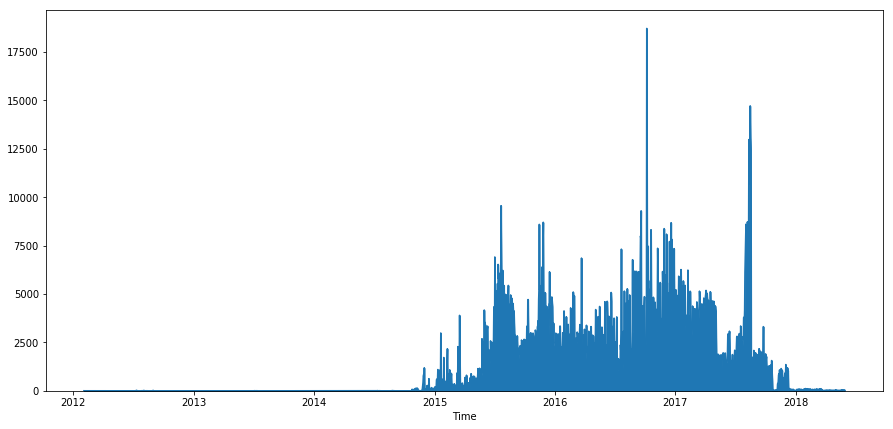

<Figure size 432x288 with 0 Axes>

In [51]:
# Complete histogram
_ = histogram(all_data_df)
plt.show()
plt.savefig("all_tweets.png")

This histogram represents the number of tweets emitted by the IRA over time. It gives good insight on the span of tweets. The first tweets appear in late 2012 and the max is reached during the US presidential campaign. The decay is assumed to be due to the discovery of these accounts.

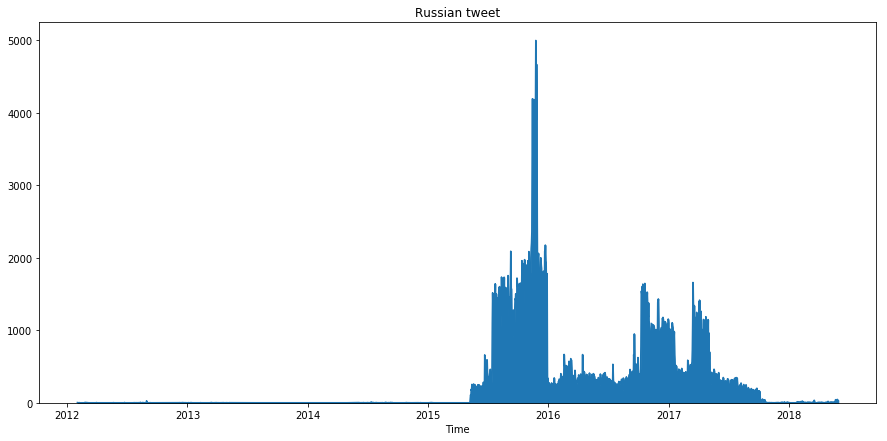

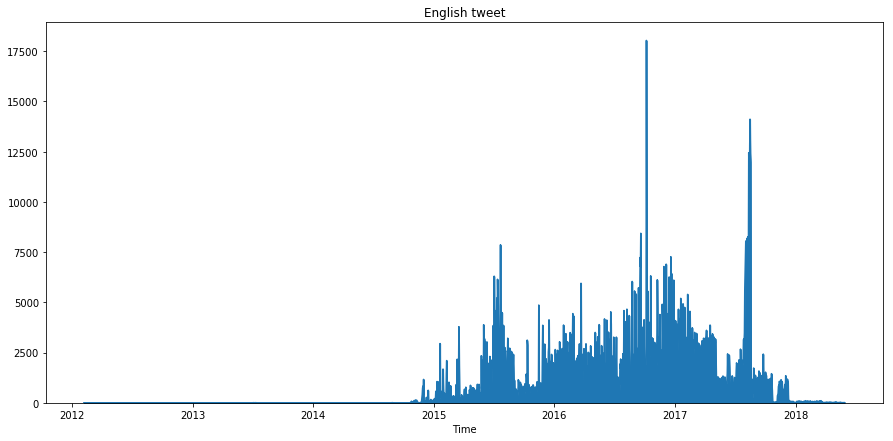

In [49]:
russian_tweet = all_data_df[all_data_df.language == 'Russian']
english_tweet = all_data_df[all_data_df.language == 'English']
_ = histogram(russian_tweet, "Russian tweet")
_ = histogram(english_tweet, "English tweet")
plt.show()

Tweets by language:
We can see that the IRA tried to influence the american elections but also made russian trolls, probably for national use. For exemple, we observe a big peak in russian tweets around the MH17 incident.

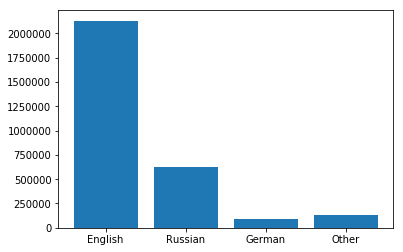

In [29]:
_df = all_data_df[['content', 'language']]
languages = _df.groupby('language').count().sort_values(['content'], ascending = False)
minor = languages[languages.content < 50000]
languages = languages[:3].append(pd.DataFrame({'language' : ['Other'], 'content': [sum(minor.content.values)]}).set_index(['language']))
other = pd.DataFrame({'languages' : ['Other'], 'content' : [np.sum(minor.values)]}).set_index(['languages'])
languages = languages.append(other)
plt.bar(languages.index,languages.content)
plt.savefig('languages')

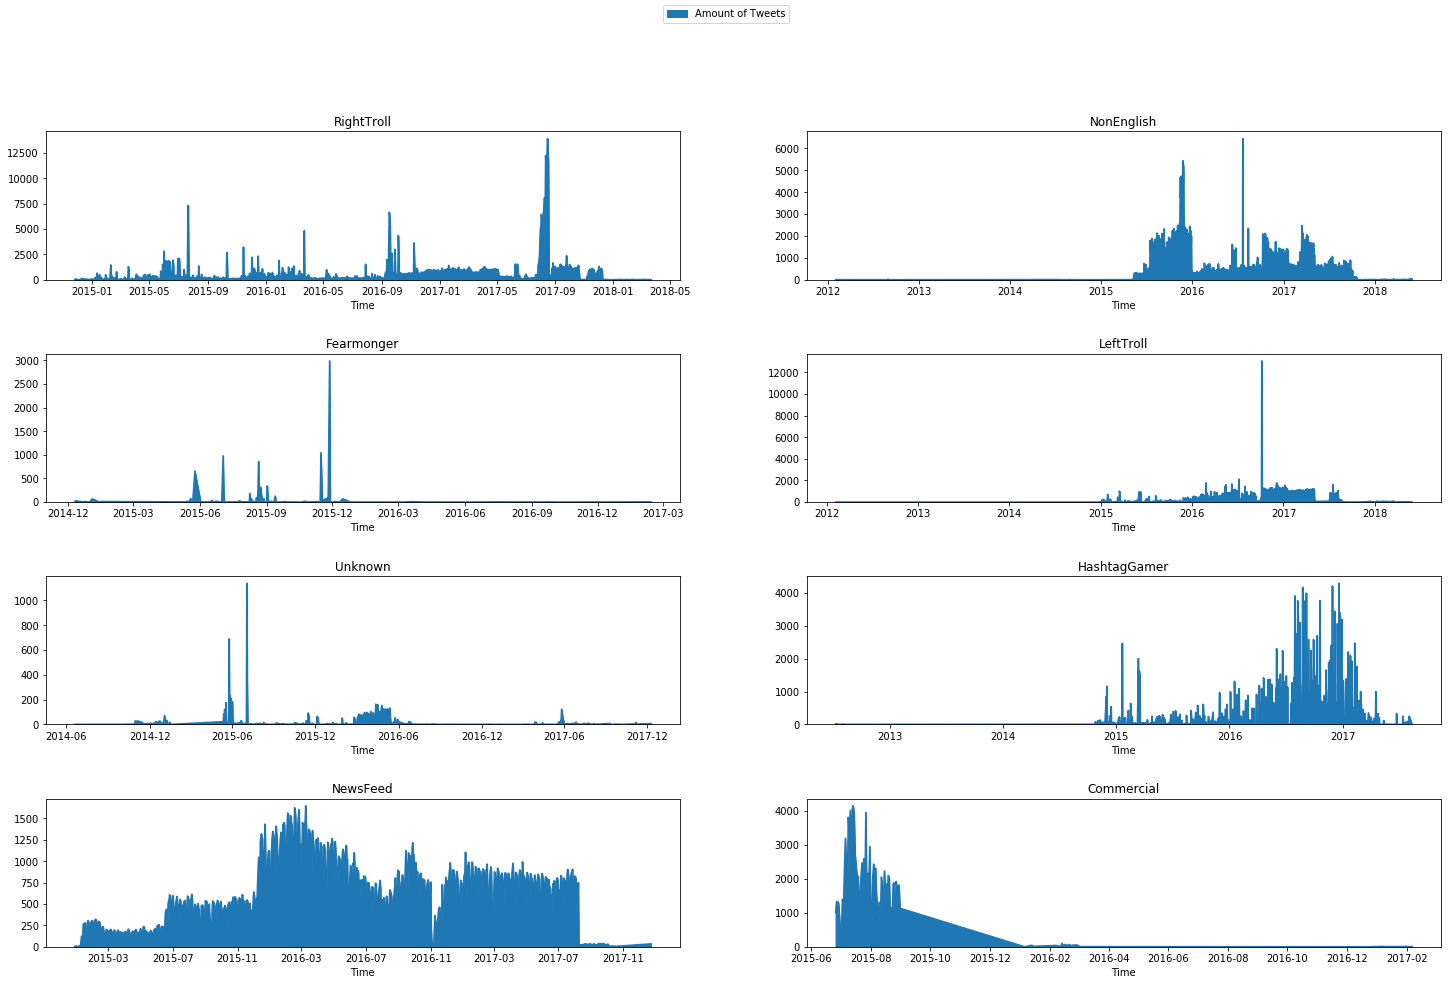

In [297]:
fig, axes = plt.subplots(nrows=4, ncols=2)
for (index, cat) in enumerate(account_categories):
    ax = axes[int(index/2), index%2]
    histogram(all_data_df, cat, cat, (25, 15), ax=ax)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.5)
plt.show()

In the dataset, tweets are organized by category. To get a better insight on these, we plot the distribution of tweets per category. 
The categories describe the type of people targeted by the accounts.

## Right Trolls

These are tweets and retweets from accounts created to impersonate republicans and promote Trump. We plotted below the most used hashtags from these accounts.

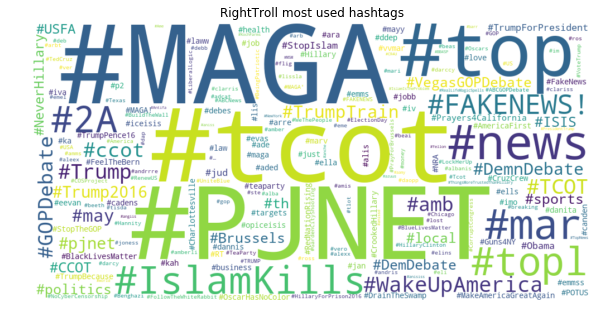

In [298]:
hashtag_graph(all_data_df, "RightTroll")

## Left Trolls

These are tweets and retweets from accounts created to impersonate democrats supporters and promote Hillary. We will see later that these trolls promoted Hillary Clinton until only to help her win against Bernie Sanders and stopped after that. We plotted below the most used hashtags from these accounts.



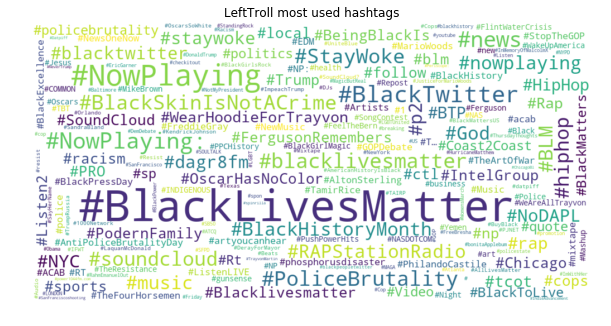

In [299]:
hashtag_graph(all_data_df, "LeftTroll")

### Imitating real users

In order to look like real users, we can see that the russians also used many commonly used hashtag.

For exemple, #NowPlaying was used a lot and often found with '#hiphop', '#RAPStationRadio', '#rap', '#music', '#power1044fm.com', '#HipHop', '#checkitout', '#EDM', '#Rap', '#HouseMusic', '#RnB', '#NewMusic', '#Reggae', '#ListenLive', '#HOuseMusic', '#Pop', '#TheIndieHour'

## Gamer trolls

Some "gamer" accounts were created where most tweets and hashtags imitate really well theses communities.



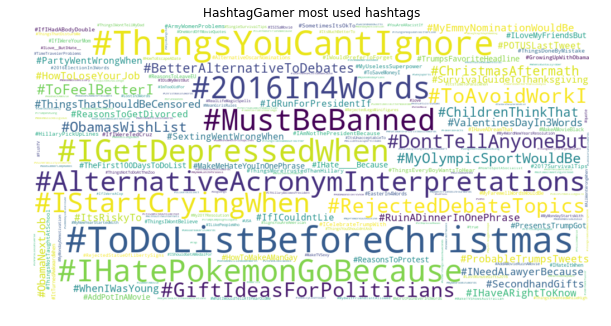

In [300]:
hashtag_graph(all_data_df, "HashtagGamer")

### NewsFeed

In [39]:
autor_news = all_data_df[all_data_df.account_category == 'NewsFeed'][['author','content']].groupby(['author']).count().sort_values(['content'], ascending = False)
collections.Counter(get_hashtags(all_data_df[all_data_df.author == 'TODAYPITTSBURGH'])).most_common(10)
collections.Counter(get_hashtags(all_data_df[all_data_df.author == 'SEATTLE_POST'])).most_common(10)

,content
author,
SCREAMYMONKEY,44041
TODAYPITTSBURGH,33602
SPECIALAFFAIR,32588
SEATTLE_POST,30800
KANSASDAILYNEWS,28890
ROOMOFRUMOR,28360
DAILYSANFRAN,28076
CHICAGODAILYNEW,22236
TODAYNYCITY,18534


### Gamer retweeting tweets against Democrats

In [92]:
keywords = ["Trump", "Pence", "GOP", "maga"]
tweets = get_tweets(all_data_df[all_data_df.language == 'English'], keywords=keywords,category='HashtagGamer', retweets_only=True)
for (tweet, nb) in collections.Counter(tweets).most_common(20):
    print("'{0}' => RETWEETED {1} times".format(tweet, nb))

'BREAKING #TrumpLeaks DONALD TRUMP OWNS STOCK IN CARRIER CORPORATIONS PARENT COMPANY  RT the F out of this! #cnn #msnbc #amjoy  @PeskyVarmt� https://t.co/NpSXe37ixO' => RETWEETED 21 times
'Surprise! #TrumpLies #DouchePence https://t.co/jq8Cm16KBg' => RETWEETED 20 times
'Trump. Death. Aleppo. Nazis. #2016In4Words' => RETWEETED 19 times
'#RESIST! Absurd that @GOP pushes for mandatory burials for fetal tissue while green-lighting an oil pipeline through burial grounds! #NoDAPL' => RETWEETED 19 times
'#ToDoListBeforeChristmas don’t let Trump ruin our country' => RETWEETED 19 times
'Subscriptions to High Times Magazine  #GiftIdeasForPoliticians' => RETWEETED 19 times
'• Trump • Celebrity Deaths  • Clowns   #2016In4Words' => RETWEETED 18 times
'#2016In4Words   Make America Great Again  #ThanksTrump �������' => RETWEETED 18 times
'#GiftIdeasForPoliticians the pronunciation app for Donald Trump when he attempts to say "huge."' => RETWEETED 18 times
'T.N.T.                                      

### Most active users

In [28]:
active = all_data_df[['author', 'publish_date']]
active = active.groupby('author').count()
active = active.sort_values(by = ['publish_date'], ascending=False).head(20).index.values

IndexError: index 4 is out of bounds for axis 0 with size 4

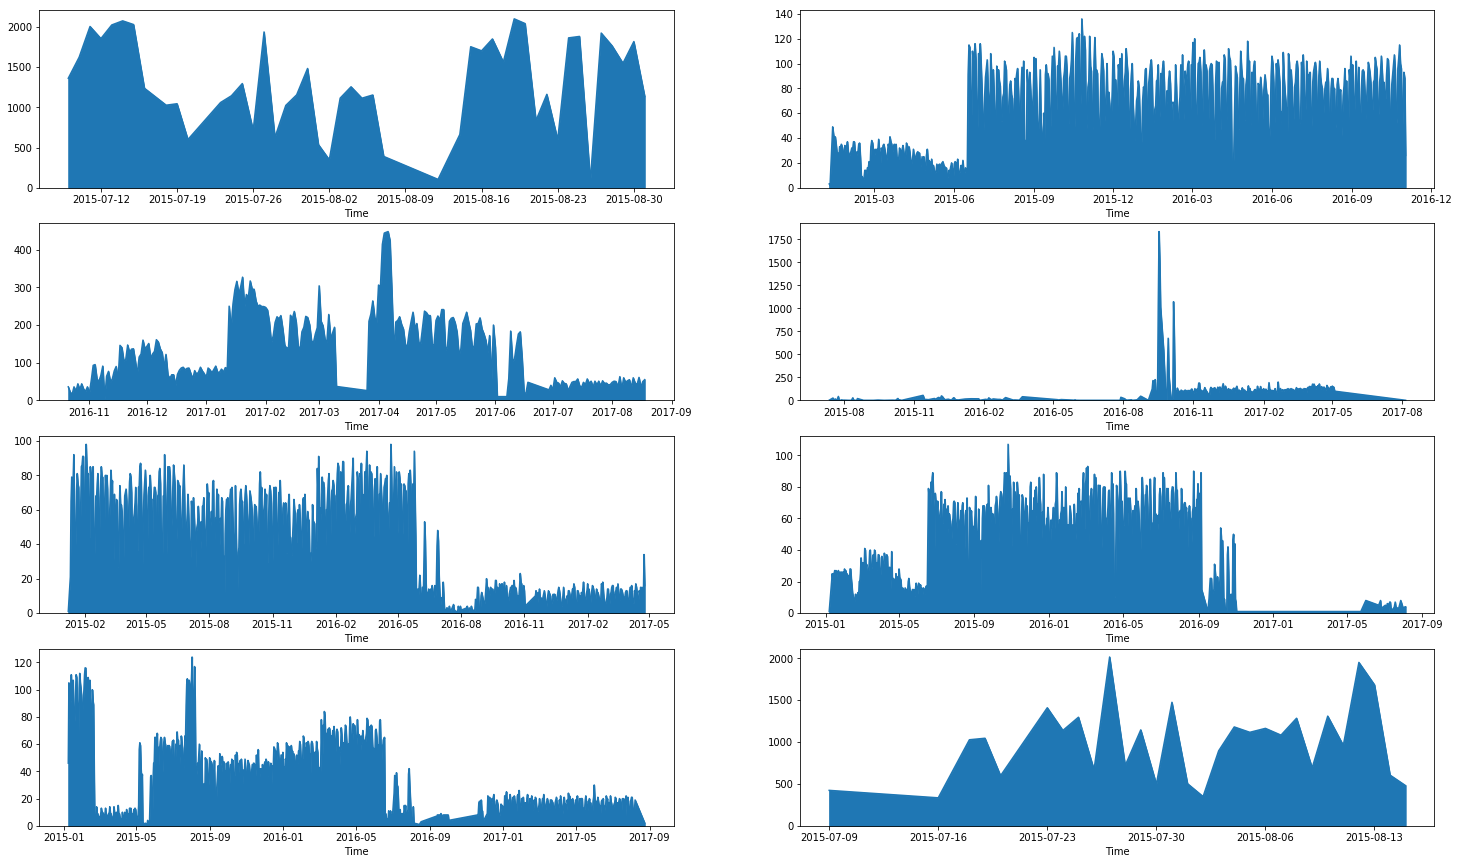

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=2)
for (index, user) in enumerate(active):
    ax = axes[int(index/2), index%2]
    histogram(all_data_df, title=str(user), author=str(user), size=(25, 15), ax=ax)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.5)
plt.show()

### Most common hashtags

In [32]:
hashtags = collections.Counter(get_hashtags(all_data_df)).most_common(10)
hashtags

[('#news', 128760),
 ('#sports', 48713),
 ('#politics', 39780),
 ('#world', 27573),
 ('#local', 25910),
 ('#TopNews', 15162),
 ('#MAGA', 12374),
 ('#health', 11485),
 ('#tcot', 11300),
 ('#BlackLivesMatter', 11276)]

### Evolution of usage of key hashtags over time, aggregated by week

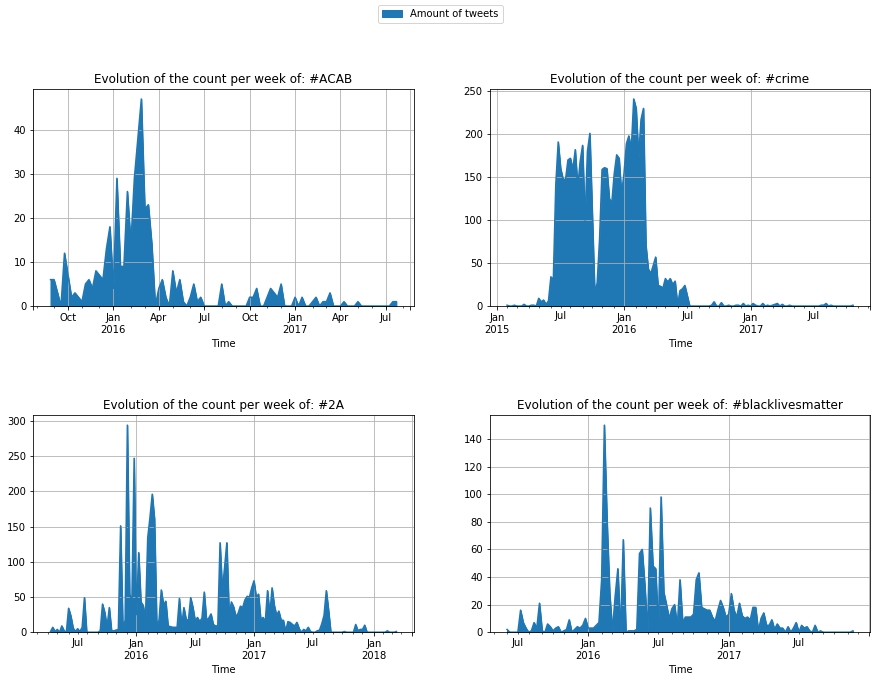

In [27]:
hashtag_over_time=["#ACAB", "#crime", "#2A", "#blacklivesmatter"]

def get_numtweets_perweek(df,hashtag, ax=None):
    df["publish_date"]= df["publish_date"].apply(lambda x: pd.to_datetime(x))
    df = df.rename(columns={"publish_date":"Time"})
    tweets= df[df["content"].str.contains(hashtag)][["Time","content"]].groupby(pd.Grouper(key='Time', freq='W')).count()
    tweets = tweets.rename(columns ={"content":"Amount of tweets"})
    title = "Evolution of the count per week of: " + hashtag
    tweets.plot(figsize=(15,10),kind="area", title = title, grid=True, ax=ax)

fig, axes = plt.subplots(nrows=2, ncols=2)

for (index, h) in enumerate(hashtag_over_time):
    ax = axes[int(index/2), index%2]
    get_numtweets_perweek(all_data_df,h, ax)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.5)
plt.savefig('hashtagsCounts.png')
plt.show()


We see that #pjnet and #tcot have some common trend tendencies. 

Something very interesting to notice is the decline for #blacklivesmatter after the win of Hillary Clinton against Bernie Sanders (July 2016). The russians probably tried to made her win against Sanders because they knew that Trump would have more chances against her.

We also see that the #maga (make america great again) started appearing only after Clinton won over Sanders, which confirms our initial theory.

### Conspiracy theory

In [35]:
qanon_cond = (all_data_df.content.str.contains('QAnon')) | (all_data_df.content.str.contains('Qanon')) | (all_data_df.content.str.contains('qanon')) | (all_data_df.content.str.contains('QANON'))
Qanon = all_data_df[all_data_df.content.apply(check(['QAnon']))]
FTWR = all_data_df[all_data_df.content.str.contains('FollowTheWhiteRabbit')]
storm = all_data_df[all_data_df.content.str.contains('storm')]
_min = np.min(Qanon.publish_date)
_max = np.max(Qanon.publish_date) 

### Self protection

[('#CorruptCongress', 358),
 ('#WeThePeople', 211),
 ('#MAGA', 190),
 ('#Mueller', 124),
 ('#FireMueller', 116),
 ('#TrumpTrain', 97),
 ('#mar', 97),
 ('#top', 92),
 ('#FireMcMaster', 76),
 ('#amb', 63)]

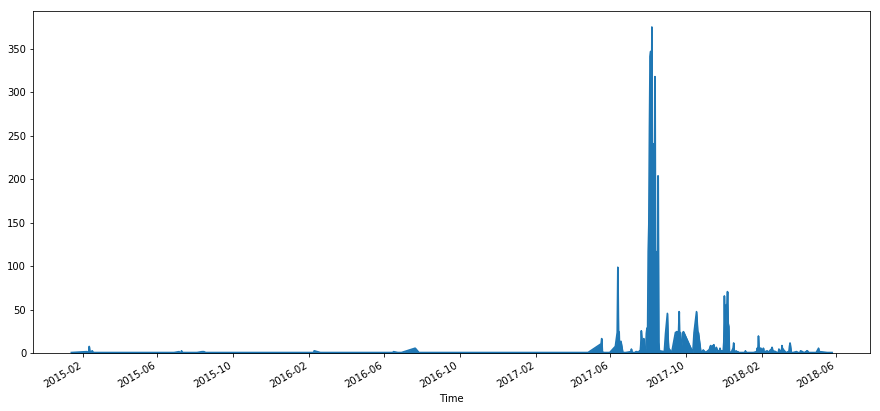

In [37]:
mueller_related = all_data_df[(all_data_df.content.str.contains('mueller')) | (all_data_df.content.str.contains('Mueller'))]
histogram(mueller_related)
collections.Counter(get_hashtags(mueller_related)).most_common(10)

### Retweet schemes

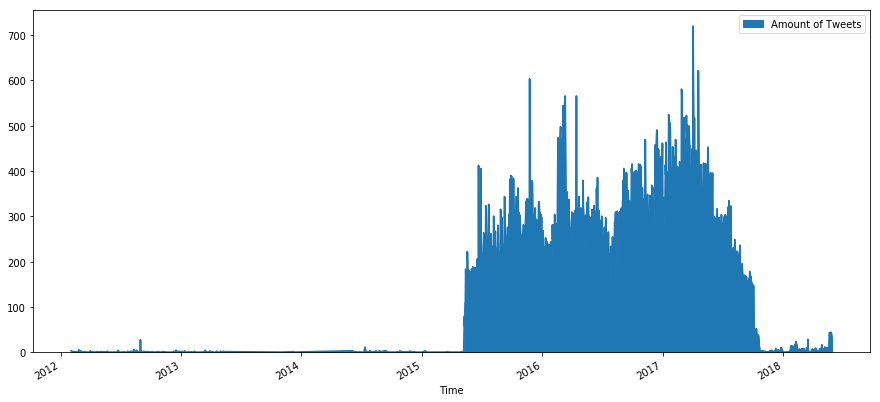

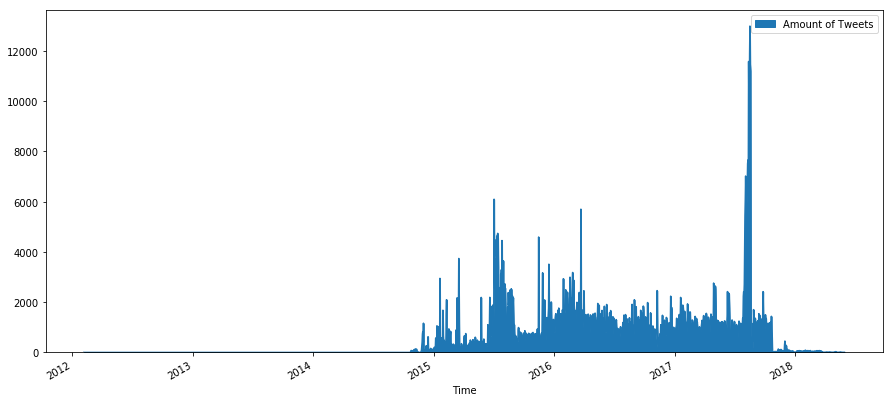

In [48]:
not_retweets = all_data_df[all_data_df.retweet == 0]
english_not_retweets = not_retweets[not_retweets.language == 'English']
russian_not_retweets = not_retweets[not_retweets.language == 'Russian']
_ = histogram(russian_not_retweets, "Russian original tweets")
_ = histogram(english_not_retweets, "English original tweets")
plt.show()

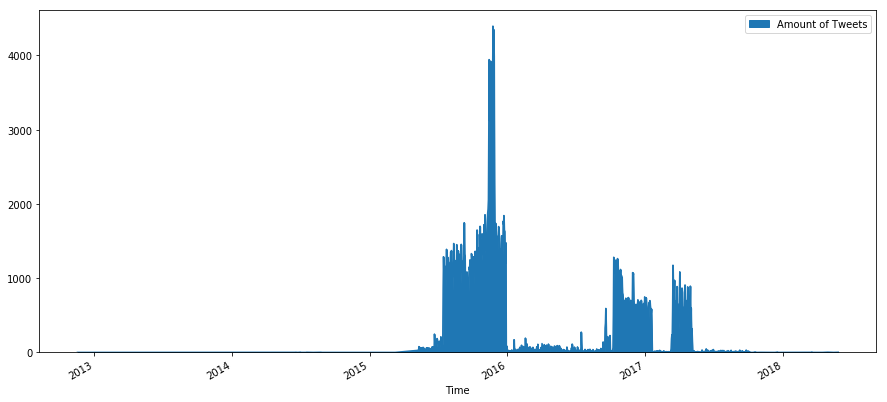

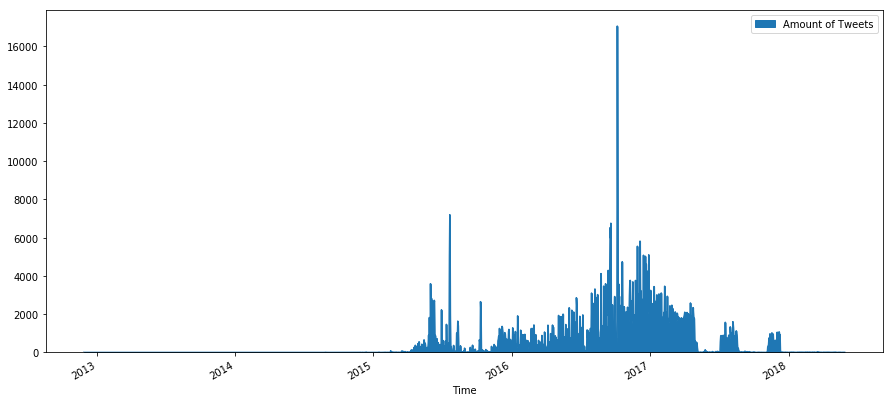

In [46]:
retweets = all_data_df[all_data_df.retweet == 1]
english_retweets = retweets[retweets.language == 'English']
russian_retweets = retweets[retweets.language == 'Russian']
_ = histogram(russian_retweets, "Russian retweets")
_ = histogram(english_retweets, "English retweets")
plt.show()

In [51]:
retweet_from_IRA = retweets[retweets.content.isin(not_retweets.content)]
retweet_from_IRA_eng = retweet_from_IRA[retweet_from_IRA.language == 'English']
retweet_from_IRA_eng[['author','content']].groupby(['content']).count().sort_values(['author'], ascending = False).head(10)

,author
content,
"So, if someone shoots me he commits a crime, if a cop shoots me he prevents one. Double standarts! #MikeBrown #Fergusonremembers",38
#walmart #KochFarms https://t.co/szzqrlBAAy https://t.co/GrTM9etEQ9,33
Smell of fried onions #ThingsYouCantIgnore,25
#ThingsYouCantIgnore a Russian plant as your next #POTUS,25
#ThingsYouCantIgnore Your moustache ... when you're a woman,25
#ThingsYouCantIgnore Bubble wrap!!! Must pop....,25
#ThingsYouCantIgnore unfortunately the flashing light in your rear view mirror,25
That fart that may not have been just a fart #ThingsYouCantIgnore,25
Our hashtag game hosted by @GiselleEvns and @DanaGeezus is #HowToMakeAManGay I bet they know how to do it,25


In [52]:
collections.Counter(get_hashtags(retweet_from_IRA)).most_common(10)

[('#news', 8914),
 ('#MAGA', 7359),
 ('#tcot', 7231),
 ('#PJNET', 5562),
 ('#BlackLivesMatter', 3425),
 ('#Trump', 3355),
 ('#NowPlaying', 3335),
 ('#ToDoListBeforeChristmas', 3093),
 ('#sports', 2902),
 ('#новости', 2737)]

In [53]:
collections.Counter(get_hashtags(retweets)).most_common(10)

[('#news', 8914),
 ('#MAGA', 7359),
 ('#tcot', 7231),
 ('#PJNET', 5562),
 ('#BlackLivesMatter', 3425),
 ('#Trump', 3355),
 ('#NowPlaying', 3335),
 ('#ToDoListBeforeChristmas', 3093),
 ('#sports', 2902),
 ('#новости', 2737)]

In [ ]:
original_retweet = []
for user in active:
    original_authors = get_original_authors(user)
    original_retweet.append((list(set(original_authors)), user))

### Retweet connections graph ##

##### Defining classes to modelise our graph

In [16]:
class Category:
    
    def __init__(self, hashtags, display_name):
        self.name = hashtags[0]
        self.display_name = display_name
        self.hashtags = hashtags
        
    def color(self, categories):
        colors = ["blue", "red", "green", "pink", "purple", "orange", "black", "#ff99ee"]
        for (i, cat) in enumerate(categories):
            if self.name == cat.name:
                return colors[i%len(colors)]
        
    def annotation_text(self, df):
        return "{} tweets".format(self.display_name)
    
    def offset(self):
        val = 0.01
        if self.name == hilary_cat.name or self.name == trump_cat.name:
            return (0, val)
        else:
            return (-val, 0)
    
    def transform(self):
        if self.name == hilary_cat.name or self.name == trump_cat.name:
            return (0, -40)
        else:
            return (-40, -40)
        
           
class Item:
    
    @staticmethod
    def author(name, tweets, categories):
        item = Item()
        item.name = name
        item.size = (len(tweets) + 30) ** 0.3
        item.symbol = "circle"
        item.score = get_score_tweets(tweets, categories)
        item.is_author = True
        item.pos = None
        return item
        
    @staticmethod
    def hashtag(cat, categories):
        item = Item()
        item.name = cat.name
        item.size = 30
        item.symbol = 21
        item.score = get_score_hashtag(cat.name, categories)
        item.is_author = False
        item.pos = None
        return item
        
    def get_values(self, with_random=False):
        if with_random:
            return [val + random.random()*0.05 for val in self.score.values()]
        else:
            return list(self.score.values())
        
    def display_text(self):
        if self.is_author:
            return self.name
        else:
            return self.most_cat().hashtags
    
    def set_pos(self, pos):
        self.pos = tuple(pos)
        
    def most_cat(self):
        return max(self.score.items(), key=operator.itemgetter(1))[0]
        
    def color(self, categories):
        return self.most_cat().color(categories)
    
    def val_max(self):
        return abs(max(self.score.items(), key=lambda tup: abs(tup[1]))[1])
        
    def is_empty(self):
        return len([val for val in self.get_values() if val != 0]) == 0
        
    def to_string(self):
        return "{0}: {1} -> {2}".format(self.name, self.get_values(), self.pos)

##### A few helper functions

In [17]:
def get_score_tweets(tweets, categories):
    score = {}
    for category in categories:
        count = len([tweet for tweet in tweets if len([h for h in category.hashtags if h in tweet]) > 0])
        score[category] = count #/ total_scores[category]
    return normalize(score)

def get_score_hashtag(name, categories):
    score = {}
    for category in categories:
#         val = 10 if category.name == hilary_cat.name else 20
        score[category] = 20 if name in category.hashtags else 0
    return normalize(score)

def normalize(score):
    mean = np.mean(list(score.values()))
    var = np.var(list(score.values()))
    if var != 0:
        score = {k: (v-mean)*1.0/var for k, v in score.items()}
    return score

def transform_pca(X):
    pca = PCA(n_components=2)
    return pca.fit_transform(X)

def transform(X):
    
    def transform_values(x):
        return np.array([-1, 1])*x[0] + np.array([1, 1])*x[1] + np.array([1, -1])*x[2]
    
    return list(map(transform_values, X))

def save(liste, name="errors"):
    with open(name, 'wb') as fp:
        pickle.dump(liste, fp)

def read(name="errors"):
    with open (name, 'rb') as fp:
        return pickle.load(fp)

##### Computing nodes 

In [18]:
def compute_nodes(df, categories, amount=1/3):
    
    # Create hashtag items
    hashtag_items = [Item.hashtag(cat, categories) for cat in categories] 

    # Create authors items
    authors_df = df.groupby("author")['content'].apply(list)
    author_items = [Item.author(author, tweets, categories) for author, tweets in authors_df.items()]

    # Filter empty items
    author_items = [item for item in author_items if not item.is_empty()]

    # Remove duplicate and outliers
    max_vals = {}
    for item in hashtag_items:
        max_vals[item.most_cat().name] = item.val_max()
    author_items_unique = []
    unique_values = set()
    for author_item in author_items:
        value = tuple(author_item.get_values())
        if value not in unique_values and author_item.val_max() < max_vals[author_item.most_cat().name]:  
            unique_values.add(value)
            author_items_unique.append(author_item)
            
    author_items_unique = list(np.random.choice(author_items_unique, int(len(author_items_unique)*amount)))
    items = author_items_unique + hashtag_items
    X = [item.get_values(with_random=True) for item in items]
    
    A = transform_pca(X)

    for (i, item) in enumerate(items):
        item.set_pos(A[i])
    
    return items

##### Computing edges 

In [35]:
def compute_edges(df, categories):
    try:
        retweet_connections = read("retweet_connections")
    except:
        # Getting all authors connections
        retweets_df = df.groupby("content")['author'].apply(list)
        all_connections = list()
        all_retweeters = [authors for authors in retweets_df.values if len(authors) > 1]
        for (i, retweeters) in enumerate(all_retweeters):
            for author1 in retweeters:
                for author2 in retweeters:
                    all_connections.append((author1, author2))




        # Filtering connections with weight > 10
        connections = set()
        counter = collections.Counter(all_connections)
        for tup, count in counter.items():
            author1, author2 = tup
            total = counter.get(tup, 0) + counter.get((author2, author1), 0)  
            if total > 10 and tup not in connections:
                connections.add((author2, author1))

        retweet_connections = list(connections)

    save(retweet_connections, "retweet_connections")
    
    # Create hashtag connections
    authors_df = df.groupby("author")['content'].apply(lambda x: [cat.name for cat in categories if \
                                                    [tweet for tweet in x if [hasht for hasht in cat.hashtags if hasht in tweet]]])
    for author, hashtags in authors_df.items():
        for hashtag in hashtags:
            retweet_connections.append((author, hashtag))
    
    return retweet_connections

##### Visualisation methods using plotly

In [36]:
def create_graph(items, connections=[]):
    G=nx.Graph()
    items_ids = {}
    for (i, item) in enumerate(items):
        items_ids[item.name] = i
        G.add_node(i, pos=item.pos)
    
    i = 0
    for (item1, item2) in connections:
        id1, id2 = items_ids.get(item1), items_ids.get(item2)
        if id1 is not None and id2 is not None:
            i = i + 1
            G.add_edge(id1, id2)
       
    print("{} authors represented".format(len(items)))
    print("{} of connections matched the authors".format(i/(len(connections)+1)))
    
    return G

def draw_plotly(items, connections, categories, df, title=""):
    G = create_graph(items, connections)
    
    data = []
        
    for edge in G.edges():
        cat = [cat for cat in categories if cat.name == items[edge[1]].name]
        if cat:
            color = cat[0].color(categories)
        else:
            if items[edge[1]].most_cat() == items[edge[0]].most_cat():
                color = items[edge[1]].color(categories)
            else:
                color = "#ffcc66"
        
        edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5,color=color),
        hoverinfo='none',
        mode='lines')
        
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
        data.append(edge_trace)
    
    annotations, X, Y, color, size, symbol, names = [], [], [], [], [], [], []
    for node in G.nodes():
        x, y = G.node[node]['pos']
        X.append(x)
        Y.append(y)
        color.append(items[node].color(categories))
        size.append(items[node].size)
        symbol.append(items[node].symbol)
        names.append(items[node].display_text())
        cat = [cat for cat in categories if cat.name == items[node].name]
        if cat:
            cat = cat[0]
            o, t = cat.offset(), cat.transform()
            ann = dict(x=x+o[0], y=y+o[1], xref='x', yref='y', text=cat.annotation_text(df), \
                       showarrow=True, arrowhead=1, ax=t[0], ay=t[1])
            annotations.append(ann)
        
    node_trace = go.Scatter(
        x=X,
        y=Y,
        text=names,
        mode="markers",
        hoverinfo='text',
        marker=dict(
            reversescale=True,
            color=color,
            size=size,
            symbol=symbol,
            line=dict(width=2)))
    
    data.append(node_trace)

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    
        
    fig = go.Figure(data=data,
                 layout=go.Layout(
                    title=title,
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=annotations,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    
    set_credentials_file(username='declete2', api_key='W71SG0hqpfJzXzjVJX2X')

    return py.iplot(fig, filename='networkx')

def draw_graph(df, categories, amount=1, title=""):
    items = compute_nodes(df, categories, amount)
    connections = compute_edges(df, categories)
    return draw_plotly(items, connections, categories, df, title=title)

##### Creating categories and timeframes

In [37]:
# Creating categories for feature vector
trump_cat = Category(["#MAGA", "#VoterFraud", "#TrumpTrain"], "Trump")
blm_cat = Category(["#BlackLivesMatter", "#Racism", "#BLM", "PoliceBrutality"], "BLM")
gamer_cat = Category(["#ToDoListBeforeChristmas", "#IGetDepressedWhen", "#IHatePokemonGoBecause"], "Gamer")
hilary_cat = Category(['#ImWithHer','#Hillary2016'], "Hillary")

main_categories = [trump_cat, blm_cat, gamer_cat, hilary_cat]

# Creating 2 timeframes
before_hilary_date = date(2016, 7, 7) # 6 juin 2016
election_date = date(2016, 11, 10) # 9 novembre 2016

before_hilary_df = all_data_df[all_data_df.publish_date < before_hilary_date]
after_hilary_df = all_data_df[(all_data_df.publish_date > before_hilary_date) & (all_data_df.publish_date < election_date)]

##### Before Hillary's election

Black Lives Matters was the most tweeted and retweeted by IRA accounts. Much more than support toward Trump or Hillary. So it seems that at this time the IRA really tried to emphasize on the topics that divide the country instead of supporting any of them.

In [38]:
draw_graph(before_hilary_df, main_categories, title="Before Hillary Clinton election (6 June 2016)")

105 authors represented
0.03259101363100914 of connections matched the authors
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~declete2/0 or inside your plot.ly account where it is named 'networkx'


##### After Hillary's election

After Hillary Clinton won at the democratic party, we see that BLM and Hillary centers got very close, this means that the people posting content about BLM were often the same people as the ones posting content about Hillary and vice-versa, as if now the IRA wanted people to make associations between BLM and Hillary support. At the same time, a lot of political content (supporting Trump) is being posted and retweeted by the IRA accounts, we also notice the apparition of gamer like users that seem to secretly support other political views (the yellow edges represents retweets to a different categories).

In [39]:
title = "After Hillary Clinton election (6 June 2016) and before actual elections."
draw_graph(after_hilary_df, main_categories, title=title)

102 authors represented
0.027503585590145953 of connections matched the authors
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~declete2/0 or inside your plot.ly account where it is named 'networkx'
